In [1]:
!unzip -q ../input/dogs-vs-cats/train.zip

In [2]:
!mkdir utils
!touch utils/__init__.py

## Utils

In [3]:
%%writefile utils/data.py
import functools
import random
import os
from copy import deepcopy
from collections import Counter

import numpy as np
import torch
from PIL import Image
from toolz import itertoolz
from torch.utils.data import Dataset


class RebalancedDataset(Dataset):

    def __init__(
        self,
        filenames: list,
        extract_label: callable,
        transforms: "albumentations.core.composition.Compose" = None,
        class_transforms: dict = None,
        label_mapping = None
    ):
        self.extract_label = functools.lru_cache(None)(extract_label)
        self._full_filenames = filenames
        self._full_classes_count = Counter(self.extract_label(x) for x in self._full_filenames)
        self._filenames = self._full_filenames
        self._transforms = transforms
        self._class_transforms = class_transforms or {}
        self._label_mapping = label_mapping or dict(enumerate(self._full_classes_count.keys()))
        self._class_to_label = dict(zip(self._label_mapping.values(), self._label_mapping.keys()))

    def __len__(self):
        return len(self._filenames)

    def __getitem__(self, i):
        filename = self._filenames[i]
        img = Image.open(filename).convert('RGB')
        img = np.array(img, dtype=np.uint8)
        label = self.extract_label(filename)
        
        transform = self._class_transforms.get(label)
        if transform:
            img = transform(image=img)["image"]
        
        if self._transforms is not None:
            img = self._transforms(image=img)["image"]

        label = self._class_to_label[label]
        return img, label

    def rebalance(self, class_ratio: dict, random_seed=None):
        """
        *Inplace* changes view on data according to given class proportion
        
        Args:
            class_ratio (dict): new class proportion, keys are class labels,
                values - ratio of class in the new view (can be not normed)

        Returns:
            self: refence on the same dataset
        """
        _state = random.getstate()
        if random_seed:
            random.seed(random_seed)
        new_counts = self.ratio_to_size(self._full_classes_count, class_ratio)
        groups = itertoolz.groupby(self.extract_label, self._full_filenames)
        
        view = []
        for label, group in groups.items():
            new_count = new_counts.get(label, 0)
            view += random.sample(group, new_count)
        random.shuffle(view)
        self._filenames = view
        
        random.setstate(_state)
        return self
    
    def set_class_transforms(self, **kwargs):
        self._class_transforms.update(kwargs)
        return self
    
    def copy(self):
        return deepcopy(self)
    
    @property
    def label_mapping(self):
        return self._label_mapping.copy()
    
    @property
    def class_to_label(self):
        return self._class_to_label.copy()
    
    @staticmethod
    def ratio_to_size(counts: dict, ratio: dict):
        if counts.keys() != ratio.keys():
            raise ValueError
        normalized_ratio = {k: v / max(ratio.values()) for k, v in ratio.items()}
        normalized_counts = {k: v / max(counts.values()) for k, v in counts.items()}

        multipliers = {k: (normalized_ratio[k] / normalized_counts[k]) for k in normalized_counts.keys()}
        normalized = {k: v / max(multipliers.values()) for k, v in multipliers.items()}

        return {k: round(v * normalized[k]) for k, v in counts.items()}

Writing utils/data.py


In [4]:
%%writefile utils/model.py
from torch import optim
from torch import nn
import torch.nn.functional as F
import torch

from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, F1Score
import pytorch_lightning as pl


def _get_sample_weight(y, class_weight, device):
    if not class_weight:
        return None
    weights = [class_weight[i] for i in y.cpu().numpy()]
    return torch.tensor(weights).to(device)


class Net(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super().__init__()
        self.disc = nn.Sequential(
            # input is (im_chan) x 64 x 64
            nn.Conv2d(im_chan, hidden_dim, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (hidden_dim) x 32 x 32
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (hidden_dim*2) x 16 x 16
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear((hidden_dim*4) * 8 * 8, 1)
#             # state size. (hidden_dim*4) x 8 x 8
#             nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=4,
#                       stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(hidden_dim * 8),
#             nn.LeakyReLU(0.2, inplace=True),

#             # state size. (hidden_dim*8) x 4 x 4
#             nn.Conv2d(hidden_dim * 8, 1, kernel_size=4,
#                       stride=1, padding=0, bias=False)
#             # Linear output! 
        )

    def forward(self, input):
        return self.disc(input)


class LitNet(pl.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        # Create model
        self.model = Net(3, 16)
        self._class_weights = class_weights

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=3e-4)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x)
        loss = F.binary_cross_entropy_with_logits(
            preds.reshape(y.shape),
            y.float(),
            _get_sample_weight(y, self._class_weights, self.device)
        )
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        auc = BinaryAUROC().to(self.device)(preds, y)
        self.log("train_auc", auc)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).reshape(labels.shape)
        acc = BinaryAccuracy().to(self.device)(preds, labels)
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)
        auc = BinaryAUROC().to(self.device)(preds, labels)
        self.log("val_auc", auc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).reshape(labels.shape)
        acc = BinaryAccuracy().to(self.device)(preds, labels)
        # By default logs it per epoch (weighted average over batches)
        self.log("test_acc", acc)
        auc = BinaryAUROC().to(self.device)(preds, labels)
        self.log("test_auc", auc)
        f1 = F1Score().to(self.device)(preds, labels)
        self.log("test_f1", f1)

Writing utils/model.py


## TRAIN

In [5]:
import glob
import os

import torch
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

from utils.data import RebalancedDataset
%load_ext autoreload
%autoreload
from utils.model import LitNet


BATCH_SIZE = 64

SEED = 10
pl.seed_everything(SEED)

aug_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=150),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]
)
transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=80),
        A.CenterCrop(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

all_files = glob.glob("train/*.jpg")
test_files = [x for x in all_files if int(x.split(".")[1]) >= 11000]
train_files = [x for x in all_files if x not in test_files]

ds = RebalancedDataset(
    train_files,
    lambda x: x.rsplit(os.path.sep, 1)[-1].split(".", 1)[0],
    transforms=transform,
    label_mapping={1: "dog", 0: "cat"}
)

test_ds = RebalancedDataset(
    test_files,
    lambda x: x.rsplit(os.path.sep, 1)[-1].split(".", 1)[0],
    transforms=transform,
    label_mapping={1: "dog", 0: "cat"}
)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [6]:
from collections import namedtuple

Experiment = namedtuple("Experiment", ["name", "ds", "model"])

experiments = [
    Experiment("balanced", ds.copy(), LitNet()),
    Experiment("raw", ds.copy().rebalance({"dog": 1, "cat": 10}), LitNet()),
    Experiment(
        "class_weights",
        ds.copy().rebalance({"dog": 1, "cat": 10}),
        LitNet(class_weights={ds.class_to_label["dog"]: 10, ds.class_to_label["cat"]: 1})
    ),
    Experiment(
        "augmentation",
        ds.copy().rebalance({"dog": 1, "cat": 10}).set_class_transforms(dog=aug_transform),
        LitNet()
    )
]

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

results = {}

for name, ds, model in experiments:
    l = len(ds)
    train_ds_length = int(0.8 * l)
    val_ds_length = l - train_ds_length

    train_ds, val_ds = torch.utils.data.random_split(ds, [train_ds_length, val_ds_length], generator=torch.Generator().manual_seed(SEED))

    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

    trainer = Trainer(
        max_epochs=30,
        accelerator="gpu",
        devices=1 if torch.cuda.is_available() else None,
        logger=CSVLogger(save_dir=f"logs/{name}/"),
        callbacks=[
            TQDMProgressBar(refresh_rate=10),
            EarlyStopping(monitor="val_auc", min_delta=0.00, patience=2, verbose=False, mode="max")
        ],
    )
    trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    results[name] = trainer.test(model=model, dataloaders=test_dl)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7409999966621399     │
│         test_auc          │    0.8153975605964661     │
│          test_f1          │    0.7151272892951965     │
└───────────────────────────┴───────────────────────────┘

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5486666560173035     │
│         test_auc          │    0.7158242464065552     │
│          test_f1          │    0.12443386018276215    │
└───────────────────────────┴───────────────────────────┘

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.643666684627533     │
│         test_auc          │    0.7124384045600891     │
│          test_f1          │    0.45729631185531616    │
└───────────────────────────┴───────────────────────────┘

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5366666913032532     │
│         test_auc          │    0.6422858238220215     │
│          test_f1          │    0.0985206887125969     │
└───────────────────────────┴───────────────────────────┘

## RESULTS

In [8]:
import pandas as pd
pd.DataFrame({k: v[0] for k, v in results.items()})

,balanced,raw,class_weights,augmentation
test_acc,0.741000,0.548667,0.643667,0.536667
test_auc,0.815398,0.715824,0.712438,0.642286
test_f1,0.715127,0.124434,0.457296,0.098521


,train_loss,train_auc,val_acc,val_auc,test_acc,test_auc,test_f1
epoch,,,,,,,
0,0.410742,0.616162,NaN,NaN,NaN,NaN,NaN
0,0.336197,0.491379,NaN,NaN,NaN,NaN,NaN
0,0.419190,0.435268,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,0.919008,0.64496,NaN,NaN,NaN
1,0.274347,0.610170,NaN,NaN,NaN,NaN,NaN


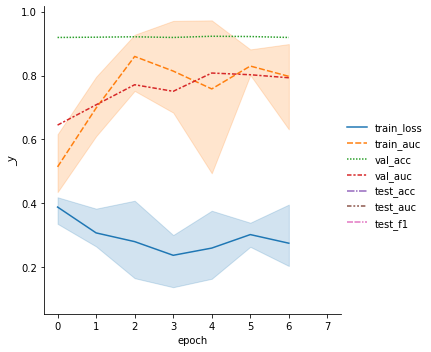

In [9]:
import pandas as pd
import seaborn as sns

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sns.relplot(data=metrics, kind="line")